## notes

making database of hashes
    * load audio file
    * generate spectrogram of data (will return frequencies, times, and amplitudes)
    * perform maximum filtering on data to help identify peaks in every region (should be evenly spaced in time and frequency)
    * get rid of all values that have changed when maximum filtering was performed (this is to keep only the peaks, makes the matrix much more sparse)
    * iterate through list of each peak coordinate, identify other peaks within nearby regions
    * create hashes that correspond to differences in peak timings and their corresponding frequencies
    * store hashes + time + track ID in big table

NOTES:
what do i need to finish?
    * create hashes and store in table
    * make into fingerprint function
    * try to get it to work first with multiple files
    * figure out how to identify songs
    * make that into a function
    * functionalize everything else that i can
    * optimize certain things with the sampling rate/frequency distributions, etc.
    * time everything to see how long this would take per song

notes on problems i've run into 
    * stereo vs. mono signals
    * converting from mp3 into wav (or just using mp3 directly)
    * need to take log of signal amplitude
    * strange results in spectrogram plotting when removing dc_offset --> disappears once maximum filtering applied
    * kdtree for generating distance map (for robust constellations)
    * fastest way to append a bunch of arrays together (or dataframes)
    * floating point precision problems when subtracting time values
    * efficient array creation with sliding windows

# Code

## Imports

In [1]:
#|default_exp shablam

In [1]:
# |export
import os
from pathlib import Path
import time
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
# from pydub import AudioSegment
from scipy.io import wavfile
from tempfile import mktemp
import scipy.spatial as spatial


## Filepaths

NOTE: ALL FILEPATHS SHOULD BE PATH OBJECTS FROM HERE ON OUT

In [113]:
file1 = Path('/Users/sunday/Downloads/DJ_Got_Us_Fallin_In_Love_Usher.wav')
file2 = Path('/Users/sunday/Downloads/Visual_Conspire_Stereo.wav')

db_filepath = Path('/Users/sunday/Desktop/projects/alakazam/alakazam_db.csv')
snippet_filepath_1 = Path('/Users/sunday/Downloads/usher_snippet.wav')
snippet_filepath_2 = Path('/Users/sunday/Downloads/Visual_Conspire_Stereo_snippet.wav')

## Functionalize Fingerprinting

In [111]:
# |export
# read music file after identifying file type from filepath Path object
# only works with .wav for now though lol
def read_audio_file(filepath):
    file_type = filepath.suffix

    if file_type == '.wav':
        sampling_rate, data = wavfile.read(filepath)  # read wav file
        data = np.mean(data, axis=1) # average the two stereo channels
    else:
        raise Exception('sorry, other file types not supported yet lol')
        
    return sampling_rate, data

# fn to remove dc offset from signal
def remove_dc(arr): return arr - np.mean(arr)

# lowpass filter to remove all frequencies below highcut value
def lowpass_filter(data, highcut, sample_rate, order=5):
    nyquist = 0.5 * sample_rate
    high = highcut / nyquist
    b, a = butter(order, high, btype='low')
    y = lfilter(b, a, data)
    return y

# load audio file, remove DC offset, apply lowpass filter w/highcut = 20kHz
def load_and_preprocess_audio(filepath):
    sample_rate, samples = read_audio_file(filepath)
    samples = remove_dc(samples)
    samples = lowpass_filter(data, 20000, sample_rate)
    return samples

# maximum filtering to identify peaks
# input: times, frequencies, amplitudes of signal from spectrogram
# output: list of points that correspond to unchanged peaks
def apply_max_filter(ts, freqs, amps):
    # time_interval and freq_interval calculated so that we can get even spacing throughout frequencies and time
    time_interval = len(ts) / np.max(ts)
    freq_interval = len(freqs) / 10

    # performing maximum filtering
    max_filter = scipy.ndimage.maximum_filter(amps, size=(freq_interval, time_interval))

    # identify which values are unchanged after doing filtering
    unchanged = max_filter == amps # unchanged = boolean matrix
    
    # get the coordinates of unchanged peaks
    # NOTE: THESE ARE THE INDICES, NOT THE VALUES THEMSELVES
    peak_freqs, peak_ts = np.where(unchanged)

    # make two column array to hold peak frequencies and times
    peak_ts_freqs = np.zeros((len(peak_freqs),2))
    
    # replace indices with corresponding times and frequencies
    peak_ts_freqs[:,0] = ts[peak_ts.astype(int)]
    peak_ts_freqs[:,1] = freqs[peak_freqs.astype(int)]
    
    # sort by time column (just seems like it'll make things easier?)
    peak_ts_freqs = peak_ts_freqs[peak_ts_freqs[:,0].argsort()]

    return peak_ts_freqs

# get track id from filepath Path object
def get_track_id(filepath): return filepath.stem

# identify all point relationships for robust constellation
def find_point_relationships(list_of_points, relationship_tree, distance):
    # initialize list to hold all relationship arrays so we can process everything at once
    temp_list = []
    
    # iterate through each point, get all points within some distance (will need to play around with distance value), filter only
    # points that are later in time, create hash, add to pandas dataframe pairwise
    num_points = len(list_of_points)
    for i in range(num_points):
        # get current point
        cur = list_of_points[i]
        
        # get all values within distance 500 of point 
        nearby = list_of_points[relationship_tree.query_ball_point(cur, distance)]
        
        # filter only points that are later in time
        after = nearby[nearby[:,0] > cur[0]]
        point_arr = np.zeros((len(after),8)) # one column for each df column, one row for each point
        
        point_arr[:,0] = cur[1] # point 1 frequencies
        point_arr[:,1] = after[:,1] # frequencies of all point 2s
        
        point_arr[:,2] = cur[0] # point 1 times
        point_arr[:,3] = after[:,0] # times of all point 2s
        
        temp_list.append(point_arr) # appending to the list is most efficient, process all at the end
    
    # concatenate all arrays in the list along the rows (axis=0)
    point_relationships = np.vstack(temp_list)
    
    return point_relationships

# fn to create song_df from array of point relationships
def create_song_df(point_relationships):
    # column names for dataframe
    columns=['f1', 'f2', 't1', 't2', 't_delta', 'hash_tuple', 'hash', 'track_id']

    # create df with all point relationships
    song_df = pd.DataFrame(data=point_relationships, columns=columns)
    
    # round each column to corresponding decimal places
    song_df = song_df.round({'f1': 3, 'f2': 3, 't1': 3, 't2': 3})

    # calculate hashes from time difference and frequencies
    song_df['t_delta'] = song_df['t2'] - song_df['t1']
    song_df['hash_tuple'] = list(zip(np.round(song_df['f1'], decimals=3), 
                                     np.round(song_df['f2'], decimals=3), 
                                     np.round(song_df['t_delta'], decimals=3)
                                    )
                                )
    song_df['hash'] = song_df['hash_tuple'].apply(hash)
    
    return song_df 
    
# fingerprint song and add to csv file
def generate_fingerprint(wav_filepath):
    # get track id for song identification
    track_id = get_track_id(wav_filepath)

    # read music file data
    sample_rate, samples = read_audio_file(wav_filepath)
    samples = remove_dc(samples) # remove DC offset

    # generate spectrogram, get frequencies, times, amplitudes
    freqs, ts, amps = scipy.signal.spectrogram(samples, sample_rate)

    # apply max filter and get list of points that correspond to unchanged peaks
    peak_ts_freqs = apply_max_filter(ts, freqs, amps)
    
    # create KDTree of all points so that we can identify neighborhoods (will be needed for 
    # robust constellations)
    kd_tree = spatial.KDTree(peak_ts_freqs)

    # find all point relationships within specified distance
    point_relationships = find_point_relationships(peak_ts_freqs, kd_tree, 200)

    # create song_df with above relationships
    song_df = create_song_df(point_relationships)

    # set track_id
    song_df['track_id'] = track_id

    # keep only the columns that we need for the csv db file
    columns_to_export = song_df[['t1', 'hash', 'track_id']].copy()

    return columns_to_export

# append to the master song hash db file
def add_song_to_db(song_filepath, db_filepath=db_filepath):
    song_fingerprint = generate_fingerprint(song_filepath) # generate fingerprint for new song
    db = pd.read_csv(db_filepath, index_col=0) # load db from file
    db = pd.concat([db, song_fingerprint], ignore_index=True) # add song df to db file
    db.to_csv(db_filepath) # save db again to same file
    return db

In [185]:
song_fingerprint_1 = generate_fingerprint(file1)
song_fingerprint_1.to_csv('shablam_db.csv')

In [188]:
begin = time.time()
appended = add_song_to_db(file2)
end = time.time()

## Identify Song

what do i need to do for this?
    * load audio file in same way as before
    * create all the same types of hashes as before
    * load file with all song hashes
    * identify matching hashes 


In [192]:
# |export
def identify_song(snippet_filepath, db_filepath=db_filepath):
    # load up the db brother
    db = pd.read_csv(db_filepath, index_col=0)
    
    # generate fingerprint in the same way as before
    snippet_df = generate_fingerprint(snippet_filepath)

    # identify rows in db_file that correspond to hashes in snippet_df
    filtered_db = db[db['hash'].isin(snippet_df['hash'])]

    # Merge the dataframes using the 'hash' column
    merged_df = pd.merge(filtered_db, snippet_df, on='hash', suffixes=('_db', '_snippet'))

    # calculate time offset of our snippet from the original file
    merged_df['offset'] = merged_df['t1_db'] - merged_df['t1_snippet']

    # find most common time offset for matching hashes
    most_common_offset = merged_df[merged_df['offset'] == merged_df['offset'].mode()[0]]

    # identify most common track id from these common time offsets
    most_likely_song = most_common_offset['track_id_db'].mode()[0]

    return most_likely_song

In [195]:
identify_song(snippet_filepath_2)

/var/folders/1w/qvf0dg610jb7nwsydxyhfc900000gp/T/ipykernel_14407/938700701.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, data = wavfile.read(filepath)  # read wav file


'Visual_Conspire_Stereo'

## fingerprinting development

In [104]:
filepath = '/Users/sunday/Downloads/usher.wav'
track_id = hash('Visual_Conspire')

In [113]:
# read .wav file data and get sample rate
sample_rate, samples = read_audio_file(filepath)  # read wav file
# samples = samples - np.mean(samples) # remove dc_offset

# generate spectrogram, get frequencies, times, amplitudes
freqs, ts, amps = scipy.signal.spectrogram(samples, sample_rate)


/var/folders/1w/qvf0dg610jb7nwsydxyhfc900000gp/T/ipykernel_14407/3321389828.py:1: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(ts,freqs,np.log(amps))


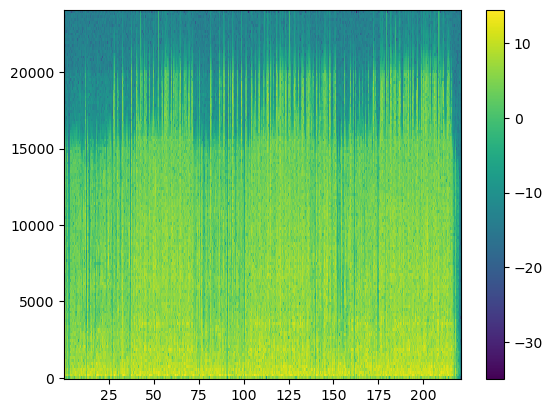

In [114]:
plt.pcolormesh(ts,freqs,np.log(amps))
plt.colorbar()

In [107]:
# maximum filtering
# time_interval and freq_interval calculated so that we can get even spacing throughout frequencies and time
time_interval = len(ts) / np.max(ts)
freq_interval = len(freqs) / 10

# performing maximum filtering
max_filter = scipy.ndimage.maximum_filter(amps, size=(freq_interval, time_interval))

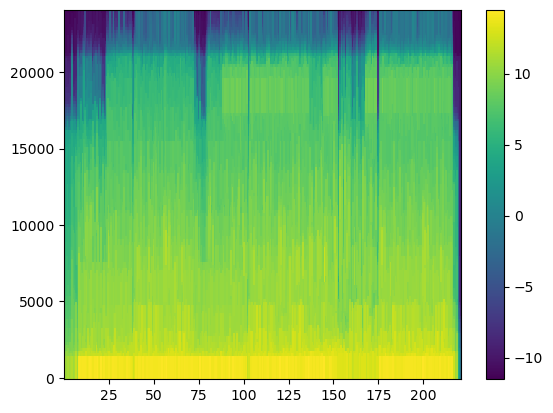

In [108]:
# plot smoothened/max filtered spectrogram
plt.pcolormesh(ts,freqs,np.log(max_filter))
plt.colorbar()

In [115]:
# identify which values are unchanged after doing filtering
unchanged = max_filter == amps # unchanged = boolean matrix

# get the coordinates of peaks that are remaining
# NOTE: THESE ARE THE INDICES, NOT THE VALUES THEMSELVES
peak_freqs, peak_ts = np.where(unchanged)

coords = zip(peak_ts, peak_freqs)

In [116]:
# make two column array to hold peak frequencies and times
peak_ts_freqs = np.zeros((len(peak_freqs),2))

# replace indices with corresponding times and frequencies
peak_ts_freqs[:,0] = ts[peak_ts.astype(int)]
peak_ts_freqs[:,1] = freqs[peak_freqs.astype(int)]

# sort by time column (just seems like it'll make things easier?)
peak_ts_freqs = peak_ts_freqs[peak_ts_freqs[:,0].argsort()]

In [117]:
# create KDTree of all points so that we can identify neighborhoods (will be needed for 
# robust constellations)
kd_tree = spatial.KDTree(peak_ts_freqs)

In [99]:
columns=['f1', 'f2', 't1', 't2', 't_delta', 'hash_tuple', 'hash', 'track_id']
num_columns = len(columns)

# initialize list to hold all relationship arrays so we can process everything at once
temp_list = []

# iterate through each point, get all points within some distance (will need to play around with it), filter only
# points that are later in time, create hash, add to pandas dataframe pairwise
num_points = len(peak_ts_freqs)

for i in range(num_points):
    # get current point
    cur = peak_ts_freqs[i]
    
    # get all values within distance 500 of point 
    nearby = peak_ts_freqs[kd_tree.query_ball_point(cur, 200)]
    
    # filter only points that are later in time
    after = nearby[nearby[:,0] > cur[0]]
    point_arr = np.zeros((len(after),num_columns)) # one column for each df column, one row for each point
    
    point_arr[:,0] = cur[1] # point 1 frequencies
    point_arr[:,1] = after[:,1] # frequencies of all point 2s
    
    point_arr[:,2] = cur[0] # point 1 times
    point_arr[:,3] = after[:,0] # times of all point 2s
    
    temp_list.append(point_arr) # appending to the list is most efficient, process all at the end

# concatenate all arrays in the list along the rows (axis=0)
point_relationships = np.vstack(temp_list)

# create df with all point relationships
song_df = pd.DataFrame(data=point_relationships, columns=columns)

# round each column to corresponding decimal places
song_df = song_df.round({'f1': 2, 'f2': 2, 't1': 3, 't2': 3})

In [66]:
song_df['t_delta'] = song_df['t2'] - song_df['t1']
song_df['hash_tuple'] = list(zip(np.round(song_df['f1'], decimals=2), 
                                 np.round(song_df['f2'], decimals=2), 
                                 np.round(song_df['t_delta'], decimals=3)
                                )
                            )
song_df['hash'] = song_df['hash_tuple'].apply(hash)
song_df['track_id'] = track_id

In [52]:
columns_to_export = song_df[['t1', 'hash', 'track_id']].copy()

In [79]:
columns_to_export

,t1,hash,track_id
0,0.638,-5428062727887350148,2160483888033806250
1,0.638,1333534921586973052,2160483888033806250
2,0.638,704117078247691982,2160483888033806250
3,0.638,-2497837088606230207,2160483888033806250
4,0.638,6872891145871429883,2160483888033806250
...,...,...,...
7750,71.972,-5165290606339709743,2160483888033806250
7751,71.972,3907728451090446970,2160483888033806250
7752,72.237,-6237587960980180836,2160483888033806250
7753,73.024,7448079146900756028,2160483888033806250


In [54]:
columns_to_export.to_csv('shablam_db.csv')

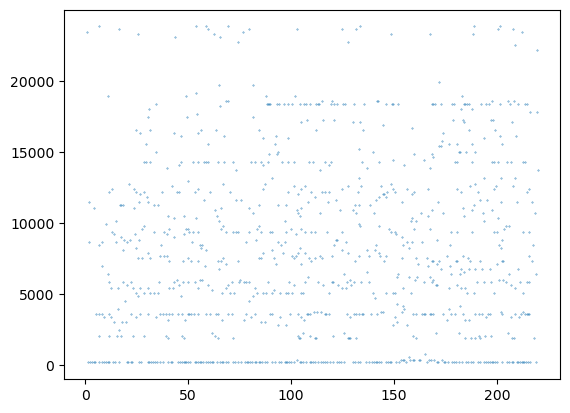

In [118]:
plt.scatter(peak_ts_freqs[:,0], peak_ts_freqs[:,1], s=0.1)

In [ ]:
# saved/backup in case I want it later
peaks_n_freqs = freqs.reshape(-1,1) * unchanged # matrix with the corresponding frequency replacing the boolean from unchanged, will make hashes easier later

## Export to python file

In [168]:
import nbdev

In [196]:
nbdev.export.nb_export('shablam.ipynb', '.')

# Deep Learning Approach

## Data Preparation

In [55]:
from scipy.signal import butter, lfilter
from pathlib import Path
from numpy.lib.stride_tricks import sliding_window_view
from PIL import Image 

what needs to be done
* load music file
* decompose into freqs, ts, amps using spectrogram
* partition into 5 second increments
* create spectrogram images out of each increment and save file as (128, 128) img
* all images should have the same y axis range and no values on the x axis (since the times will be incorrect anyway)

In [86]:
path = Path('/Users/sunday/Desktop/projects/alakazam')

In [116]:
def plot_n_save_spec(ts, freqs, amps, save_path=None):
    plt.pcolormesh(ts,freqs,np.log(amps), vmin=-20, vmax=20)
    plt.ylim([0,20000])
    plt.tick_params(
        axis='x',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False)
    plt.colorbar()
    if save_path is not None:
        plt.savefig(save_path)
        plt.clf()
    

def generate_sliding_window_arr(data, sample_rate, window_in_seconds):
    window = int(window_in_seconds/(1/sample_rate)) # corresponds to N seconds of audio
    sliding_windows = sliding_window_view(data, window)[::sample_rate, :] # create subsets of N second increments by applying sliding window every 1 second
    return sliding_windows

def save_spec_imgs_for_audio(audio_filepath):
    track_id = get_track_id(filepath) # get track name
    os.mkdir(path/track_id) # make empty folder with track name (in alakazam directory)

    # read music file data
    sample_rate, samples = read_audio_file(filepath)
    samples = remove_dc(samples) # remove DC offset
    
    # apply bandpass filter to signal to restrict frequencies between 0 - 20 kHz
    highcut = 20000
    samples = lowpass_filter(samples, lowcut, highcut, sample_rate)
    
    # generate sliding window array for song
    window_arr = generate_sliding_window_arr(samples, sample_rate, 5)

    # for each segment of audio that we've now split, generate spectrogram, plot, save
    for i,segment in enumerate(window_arr):
        # generate spectrogram, get frequencies, times, amplitudes
        freqs, ts, amps = scipy.signal.spectrogram(segment, sample_rate)
        img_name = 'img_' + str(i) + '.png'
        plot_n_save_spec(ts, freqs, amps, save_path=path/track_id/img_name)


In [ ]:
save_spec_imgs_for_audio(file1)

## Image Resizing

In [78]:
import glob

In [100]:
folder_path_1 = Path('/Users/sunday/Desktop/projects/alakazam/DJ_Got_Us_Fallin_In_Love_Usher')
folder_path_2 = Path('/Users/sunday/Desktop/projects/alakazam/Visual_Conspire_Stereo')

In [104]:
def resize_all_imgs_in_folder(folder_path, size=(256,192)):
    track_id = folder_path.name
    os.chdir(folder_path)
    resized_imgs_folder_path = folder_path/f'{track_id}_resized_imgs'
    os.mkdir(resized_imgs_folder_path)
    original_pngs = glob.glob('./*.png')
    for png in original_pngs:
        image = Image.open(png)
        new_image = image.resize(size)
        new_file_name = 'resized_' + png.split('/')[1]
        new_image.save(resized_img_folder_path/new_file_name)

## Image Creation Development

In [73]:
# read music file data
sample_rate, samples = read_audio_file(file2)
samples = remove_dc(samples) # remove DC offset

# apply bandpass filter to signal to restrict frequencies between 0 - 20 kHz
lowcut = 10
highcut = 20000
samples = bandpass_filter(samples, lowcut, highcut, sample_rate)

# generate sliding window array for song
window_arr = generate_sliding_window_arr(samples, sample_rate, 5)


In [74]:
window_arr.shape

(71, 220500)

In [70]:
# for each segment of audio that we've now split, generate spectrogram, plot, save
for i,segment in enumerate(window_arr):
    # generate spectrogram, get frequencies, times, amplitudes
    freqs, ts, amps = scipy.signal.spectrogram(segment, sample_rate)
    img_name = 'img_' + str(i) + '.png'
    plot_n_save_spec(ts, freqs, amps, save_path=path/track_id/img_name)



<Figure size 640x480 with 0 Axes>

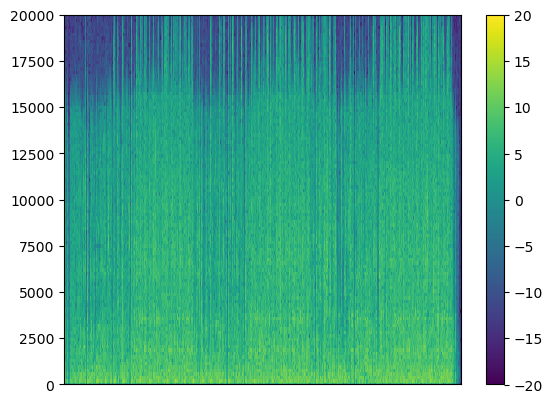

In [58]:
plot_n_save_spec(ts,freqs,amps,save_path=path/'usher_test'/'test_img2.png')

In [34]:
sample_rate

48000

In [38]:
len(samples)/sample_rate

220.9959375

In [43]:
window = int(5/(1/sample_rate)) # corresponds to 5 seconds of audio

In [48]:
sliding_windows = sliding_window_view(samples, window)[::sample_rate, :] # create subsets of 5 second increments by applying sliding window every 1 second

In [49]:
sliding_windows.shape

(216, 240000)